In [1]:
import os
import numpy as np
import skimage.io
import tensorflow as tf
import sys

import cv2
import json
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model

sys.path.insert(0, '../') 
import retriever
from CDND import Model as cdnd

# Mask RCNN imports
sys.path.insert(0, '../Mask_RCNN')
import coco
import utils
import model as modellib
import visualize

Using TensorFlow backend.


In [2]:
# Root directory of the project
ROOT_DIR = '../'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "demo_images")

vocab_file =  os.path.join(ROOT_DIR, 'data/metadata/w2v_vocab.json')
embed_path =  os.path.join(ROOT_DIR, 'data/metadata/w2v.bin')
params_dir = os.path.join(ROOT_DIR, 'data/training/models/All/unorder1_RL/EXP/CDNdrop')

# w2c words vectors
embed_vecs = np.load(open(embed_path, 'rb')).astype(np.float32)
# vocabulary
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

In [4]:
# Get image meta data
def imgMeta(img_name):
    #filename = os.path.join(IMAGE_DIR+'Mask1/Mask_RCNN/images', img_name)
    filename =os.path.join(IMAGE_DIR, img_name)
    image = skimage.io.imread(filename)
    meta = model.detect([image], verbose=1)
    return image, meta[0] 

# Get bboxes embeddings
def bboxVec(image, meta):
    bboxes = []
    spat = []
    for b in meta['rois']:
        bTrans = np.array([b[1]-1, b[0]-1, b[3]-1, b[2]-1])
        imsize = np.array([image.shape[1], image.shape[0]])
        spat.append(retriever.compute_spatial_feat(bTrans, imsize))
        
        
        RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        crop = RGB_im[b[0]:b[2],b[1]:b[3],:]
        resized_image = cv2.resize(crop, (224,224)) 
        resized_image=resized_image.astype(np.float32, copy=False)
        resized_image[:,:,0] -= 103.939
        resized_image[:,:,1] -= 116.779
        resized_image[:,:,2] -= 123.68
        v = vgg_model.predict(np.array([resized_image]))
        bboxes.append(v)
    
    return np.concatenate([bboxes, spat], 2)

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)
VGG = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)
vgg_model = Model(VGG.input, VGG.layers[-2].output)

In [6]:
def ground(img_name, q):
    image, meta = imgMeta(img_name)
    bboxes = bboxVec(image, meta)
    tf.reset_default_graph()
    m = cdnd(batch_size=1)

    Qidx = [vocab[w] for w in q.split(' ')]
    images=bboxes[:,:,:4096] 
    spat=bboxes[:,:,4096:]

    scores=m.predict(queries=[Qidx], img=images, bboxes=spat, attn_idx=[[1 for _ in range(images.shape[0])]])
    label = np.argmax(scores)
    
    a = np.array([0])
    for i in range(meta['masks'].shape[0]):
        for j in range(meta['masks'].shape[1]):
            if meta['masks'][i,j][label]==0:
                meta['masks'][i,j]=a

    visualize.display_instances(image, meta['rois'], meta['masks'], meta['class_ids'], class_names)
    return image, label, meta

Processing 1 images
image                    shape: (480, 360, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


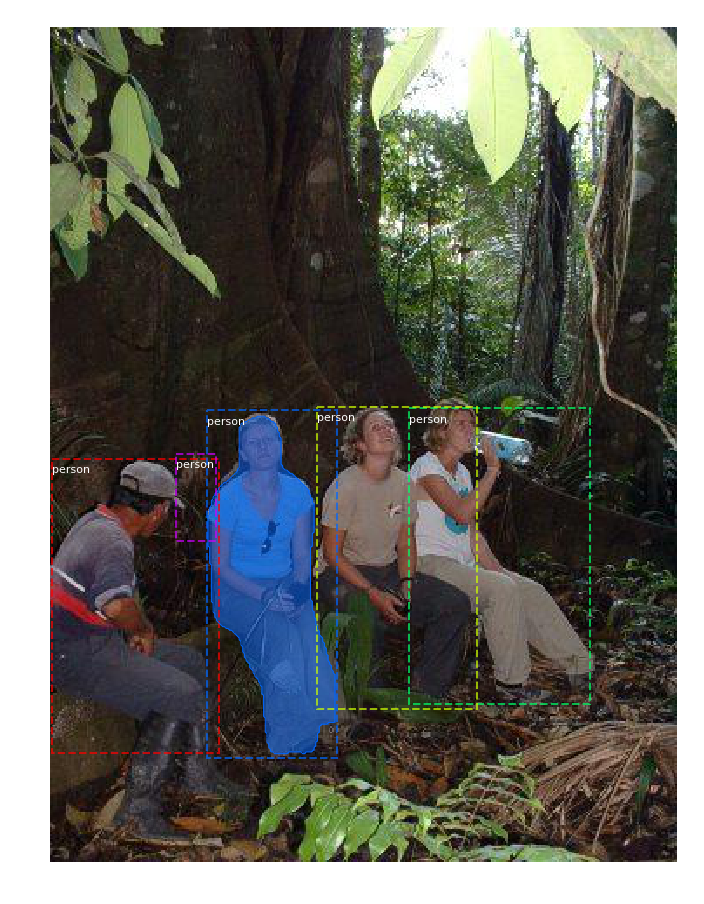

In [7]:
image, label, meta = ground('2496.jpg', 'the woman on the right of the left man')

Processing 1 images
image                    shape: (480, 360, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


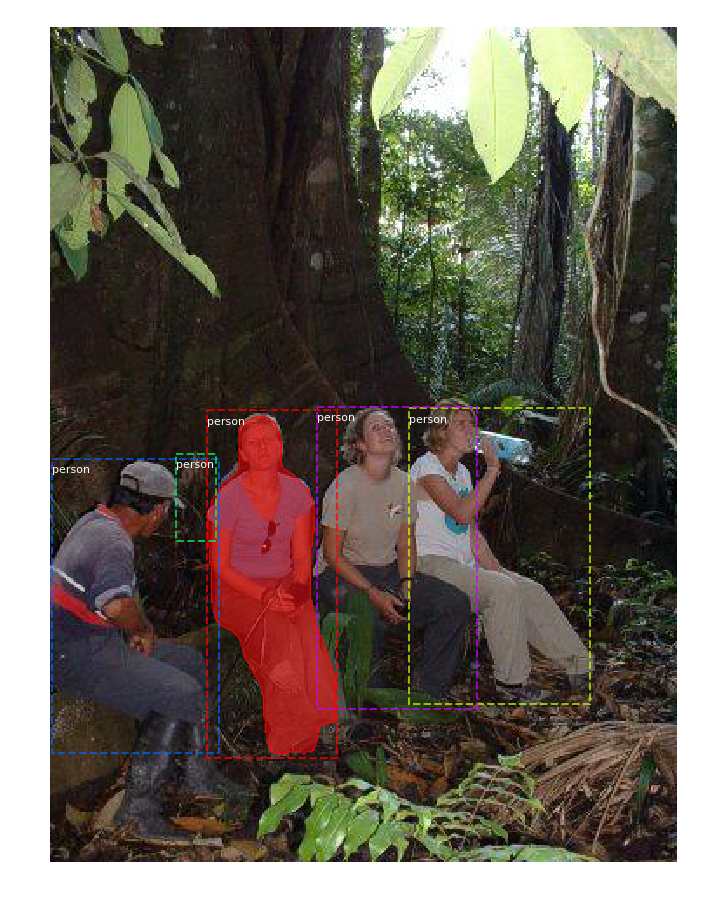

In [33]:
image, label, meta = ground('2496.jpg', 'the woman on the right of the left man')

Processing 1 images
image                    shape: (360, 480, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


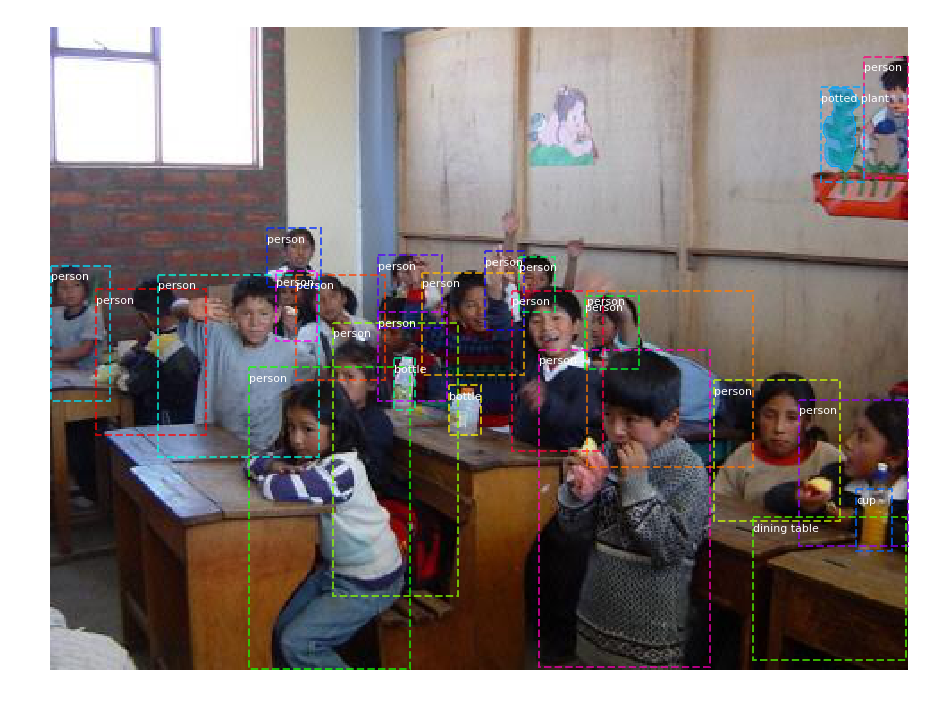

In [14]:
image, label, meta = ground('684.jpg', 'small picture on the wall')

Processing 1 images
image                    shape: (360, 480, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


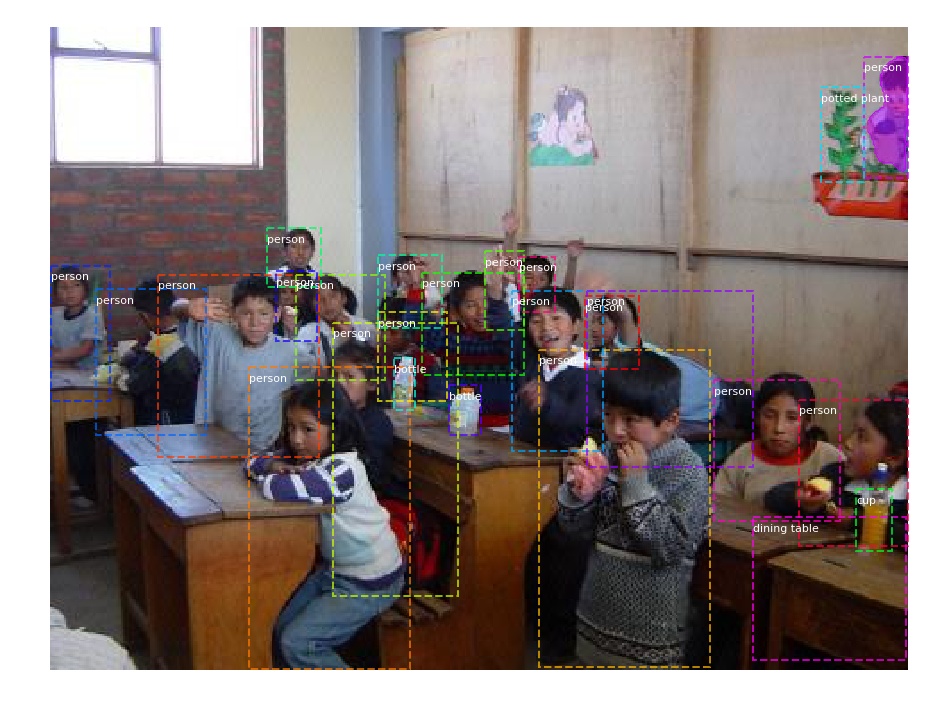

In [13]:
image, label, meta = ground('684.jpg', 'picture on the right wall')

Processing 1 images
image                    shape: (360, 480, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


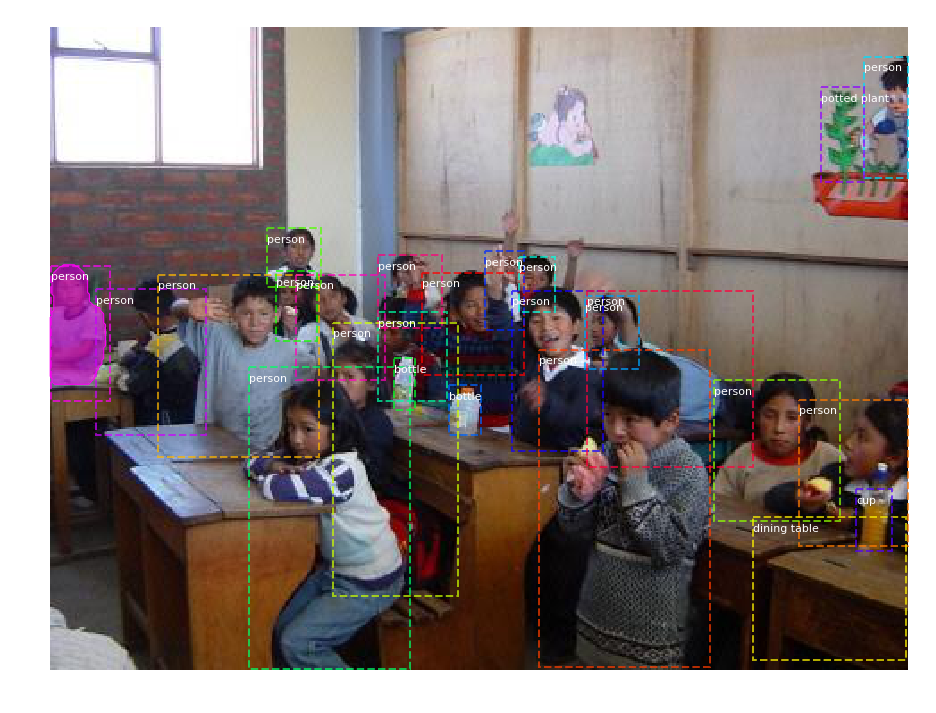

In [12]:
image, label, meta = ground('684.jpg', 'kid on the left table')

Processing 1 images
image                    shape: (480, 360, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


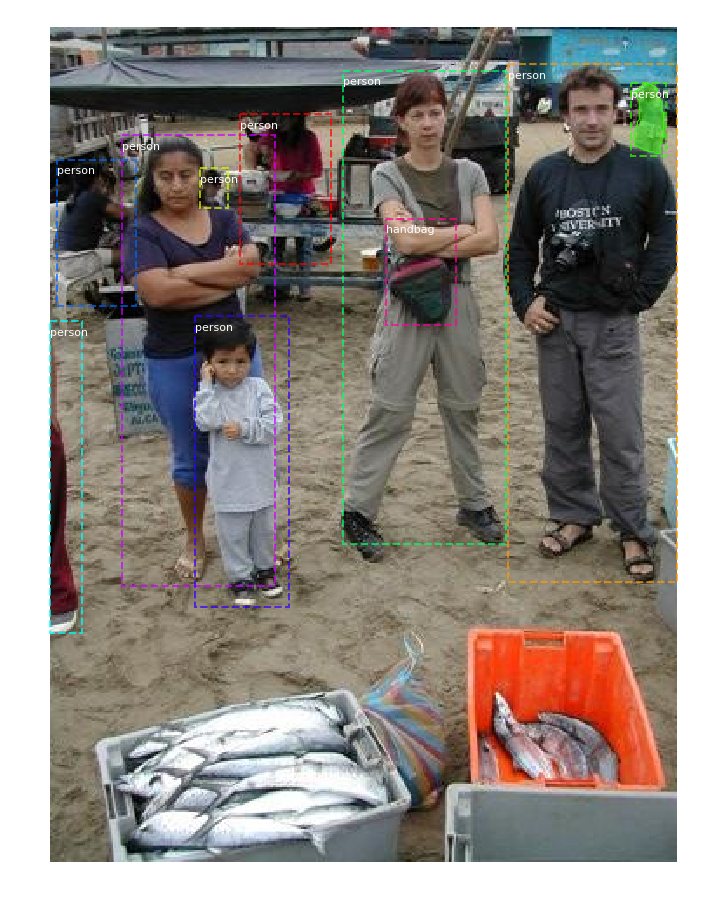

In [9]:
image, label, meta = ground('9331.jpg', 'behind the man on the right')

Processing 1 images
image                    shape: (480, 360, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


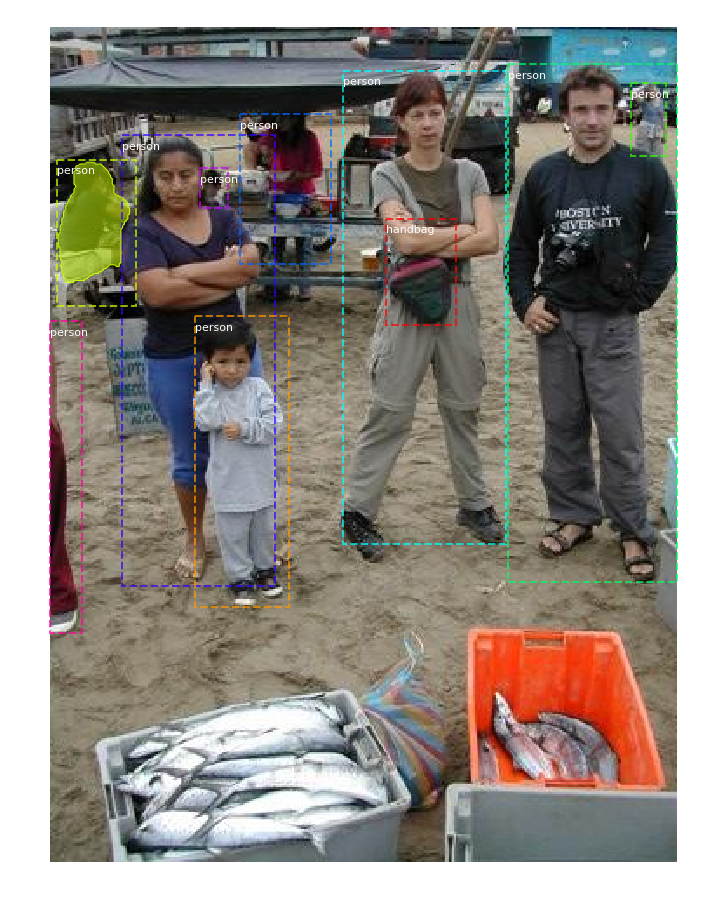

In [8]:
image, label, meta = ground('9331.jpg', 'behind the woman on the left')

Processing 1 images
image                    shape: (480, 360, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


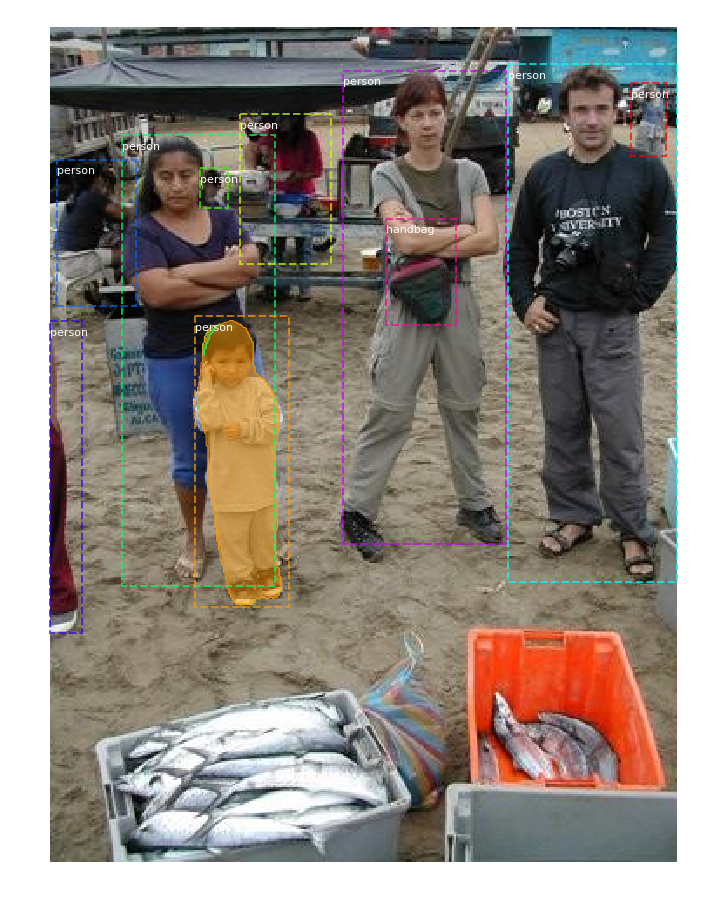

In [7]:
image, label, meta = ground('9331.jpg', 'the kid')

Processing 1 images
image                    shape: (438, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


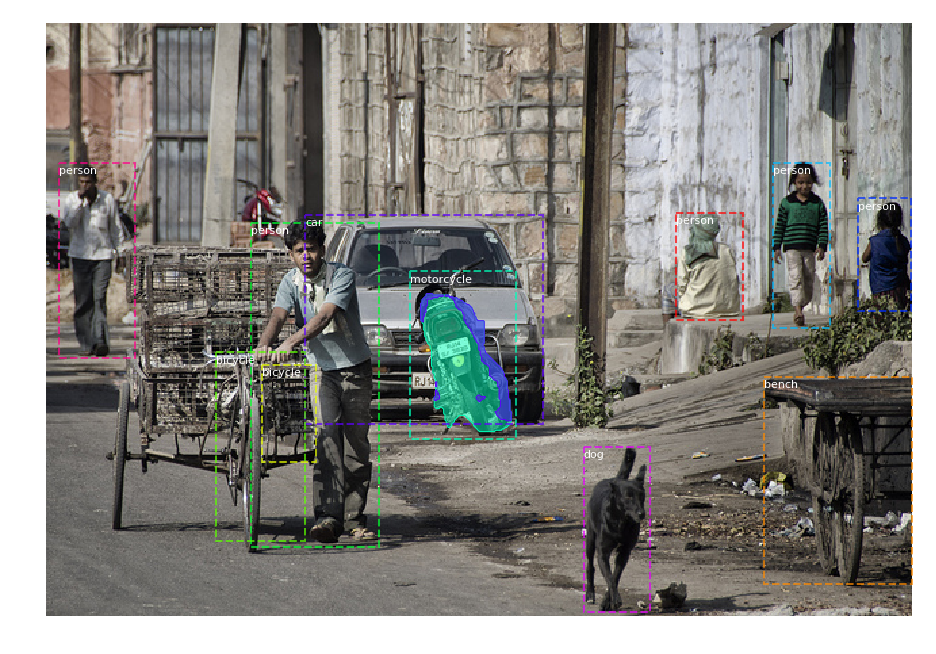

In [9]:
image, label, meta = ground('6821351586_59aa0dc110_z.jpg', 'the thing in front of the car')

Processing 1 images
image                    shape: (438, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


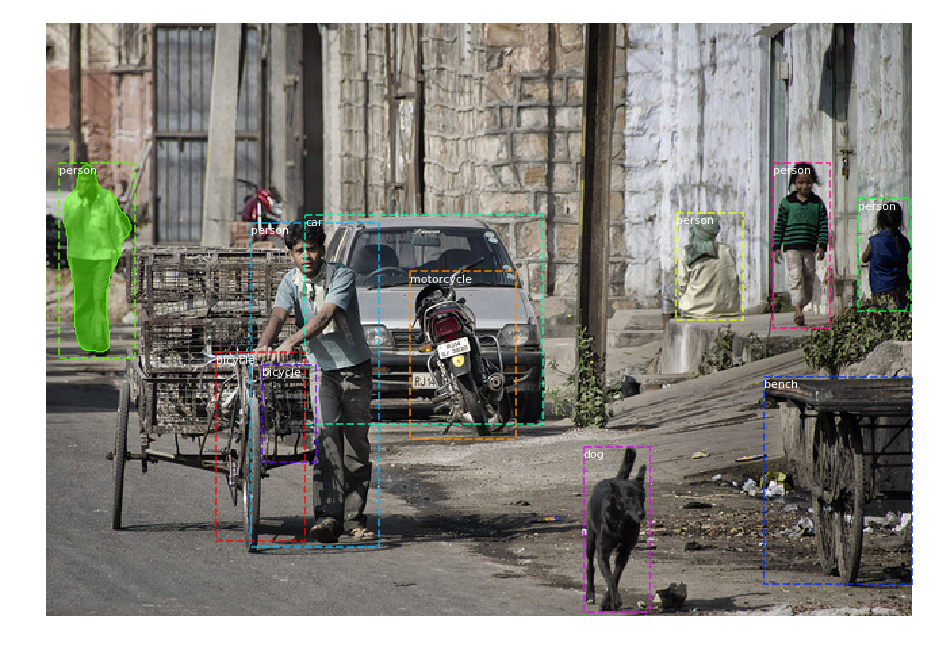

In [11]:
image, label, meta = ground('6821351586_59aa0dc110_z.jpg', 'the man on left background')

Processing 1 images
image                    shape: (438, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


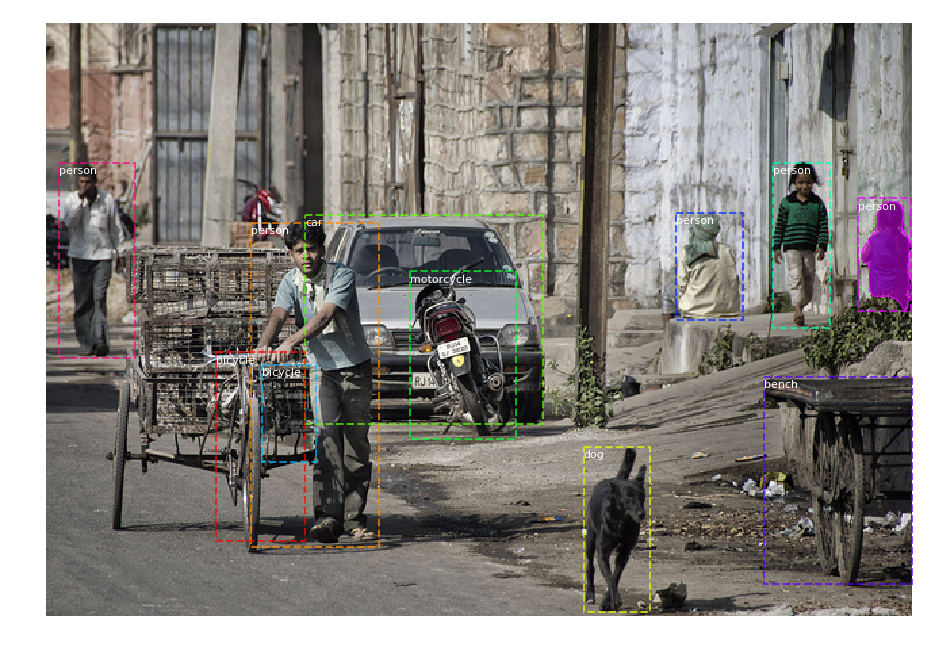

In [10]:
image, label, meta = ground('6821351586_59aa0dc110_z.jpg', 'the kid on right background')

Processing 1 images
image                    shape: (480, 360, 3)         min:    0.00000  max:  243.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  128.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


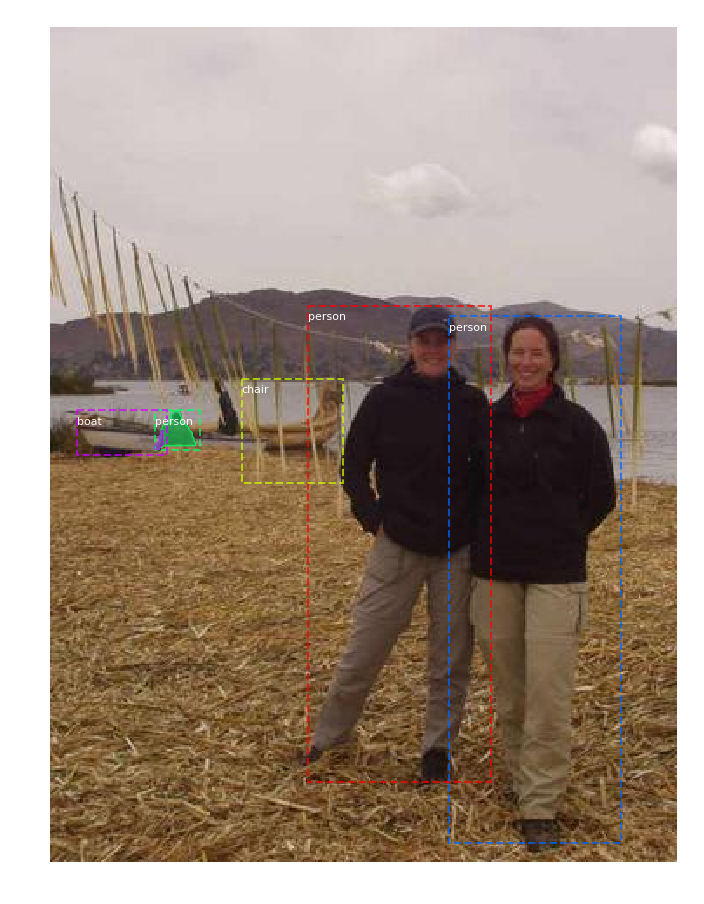

In [49]:
image, label, meta = ground('8905.jpg', 'left man')

Processing 1 images
image                    shape: (480, 360, 3)         min:    0.00000  max:  243.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  128.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Loading parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99
INFO:tensorflow:Restoring parameters from /home/asi/Desktop/GAB/CDNDParams/model.ckpt-99


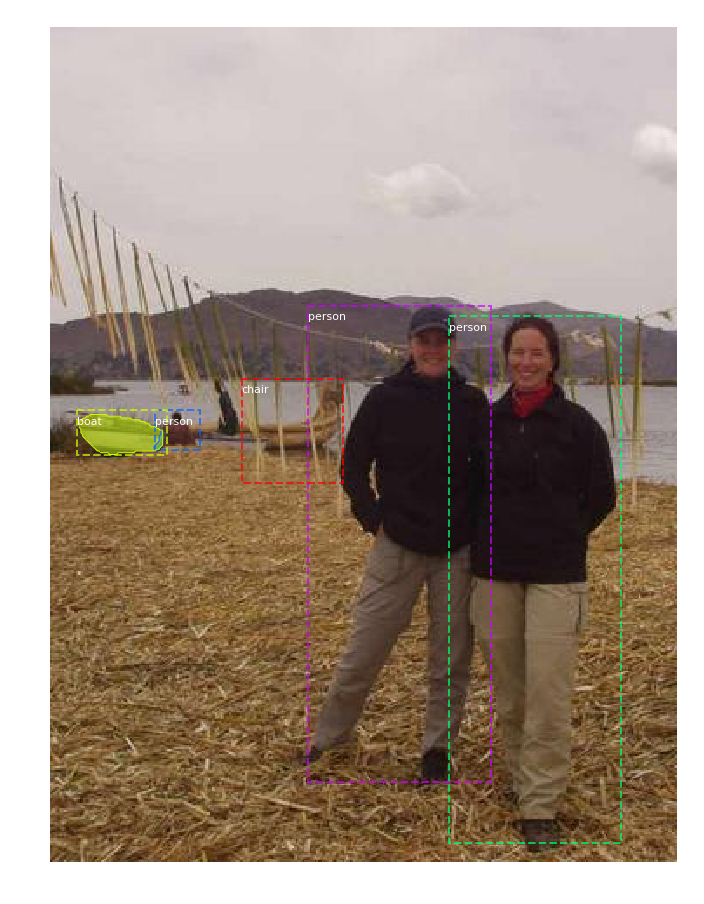

In [51]:
image, label, meta = ground('8905.jpg', 'left not man')